# Using Stable Diffusion to generate dataset examples
We explore using a fine-tuned version of Stable Diffusion to generate examples of satellite images. Tested using SageMaker Studio, PyTorch 2.0 Python 3.10 GPU kernel on g4dn.xlarge.

In this tutorial, we go through using LoRA and Dreambooth to fine-tune Stable Diffusion, a text-to-image generation model, to generate additional satellite images to augment your dataset.

In [1]:
!nvidia-smi

Fri Jun 23 04:12:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   26C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
!pip install transformers accelerate>=0.16.0 ftfy tensorboard Jinja2 huggingface_hub wandb kaggle git+https://github.com/huggingface/diffusers

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-2qt2h00v
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sparkmagic 0.20.5 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.
sparkmagic 0.20.5 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.0.1 which is incompatible.
sphinx 7.0.0 requires docutils<0.20,>=0.18.1, but you have docutils 0.16 which is incompatible.


## Setup Kaggle
Follow the instructions [here](https://github.com/Kaggle/kaggle-api#api-credentials) to get your Kaggle credentials.
Open the JSON file on your computer and update the username and key with your values. 

UPDATE WITH YOUR CREDENTIALS

In [ ]:
%%writefile ./home/ec2-user/.kaggle/kaggle.json
{"username":"ENTERUSERNAME","key":"ENTERKEY"}

In [32]:
!kaggle datasets download apollo2506/eurosat-dataset

100%|█████████████████████████████████████▉| 2.04G/2.04G [01:32<00:00, 25.5MB/s]
100%|██████████████████████████████████████| 2.04G/2.04G [01:32<00:00, 23.7MB/s]


### Dataset
For this tutorial, we will use the EuroSAT dataset, which is a land use classification dataset consisting of Sentinel 2 Satellite images. We will use the `Highway` class as the type of satellite image that we would like to generate. The `Forest` and `Industrial` classes serve as the *class* that we want the model to separate the `Highway` *instance*. Check out the original [Dreambooth paper](https://dreambooth.github.io/) to find out more.

In these commands -q supresses printing messages, -d switches the directory. This does take a bit of time. 

In [4]:
!mkdir -p ./studies/Sagemaker_Study/SI/Highway
!unzip -q eurosat-dataset.zip "EuroSAT/Forest/*" -d "./studies/Sagemaker_Study/SI/Highway/Forest"

In [5]:
!unzip -q eurosat-dataset.zip "EuroSAT/Industrial/*" -d "./studies/Sagemaker_Study/SI/Highway/Industrial"

In [6]:
!unzip -q eurosat-dataset.zip "EuroSAT/Highway/*" -d "./studies/Sagemaker_Study/SI/Highway/Highway"

## View Dataset
Let's view the `Highway` class of the EuroSAT dataset

In [7]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

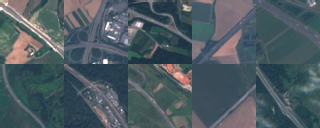

In [9]:
actual_img = [Image.open("./studies/Sagemaker_Study/SI/Highway/Highway/EuroSAT/Highway/Highway_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

Let's view the `Forest` and `Industrial` classes:

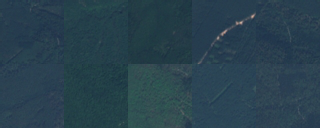

In [11]:
actual_img = [Image.open("./studies/Sagemaker_Study/SI/Highway/Forest/EuroSAT/Forest/Forest_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

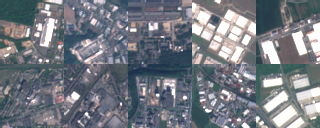

In [13]:
actual_img = [Image.open("./studies/Sagemaker_Study/SI/Highway/Industrial/EuroSAT/Industrial/Industrial_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

In [14]:
import shutil, os
forest_files = os.listdir("./studies/Sagemaker_Study/SI/Highway/Forest/EuroSAT/Forest")
industrial_files = os.listdir("./studies/Sagemaker_Study/SI/Highway/Industrial/EuroSAT/Industrial")

In [15]:
!mkdir -p "./studies/Sagemaker_Study/SI/Highway/class"

In [16]:
for filename in forest_files:
    shutil.copyfile(
        os.path.join("./studies/Sagemaker_Study/SI/Highway/Forest/EuroSAT/Forest",filename),
        os.path.join("./studies/Sagemaker_Study/SI/Highway/class",filename)
    )
for filename in industrial_files:
    shutil.copyfile(
        os.path.join("./studies/Sagemaker_Study/SI/Highway/Industrial/EuroSAT/Industrial",filename),
        os.path.join("./studies/Sagemaker_Study/SI/Highway/class",filename)
    )

## Base model Stable Diffusion generation
Let's use Stable Diffusion (1.5) directly to generate satellite images of the `Highway` class. 

In [19]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.18.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [20]:
img_list = pipe(["Sentinel 2 satellite image of a highway"]*10, num_inference_steps=10).images

  0%|          | 0/10 [00:00<?, ?it/s]

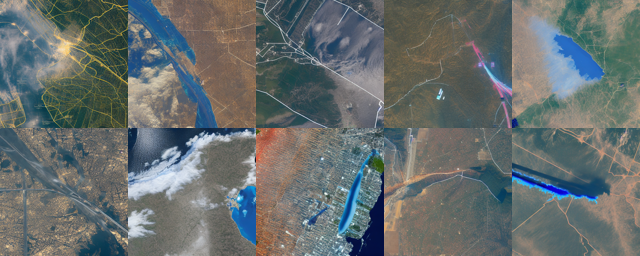

In [21]:
image_grid([x.resize((128,128)) for x in img_list], 2,5)

In [22]:
import gc
from numba import cuda
del(pipe)
gc.collect()
torch.cuda.empty_cache()


## Actual highway class images

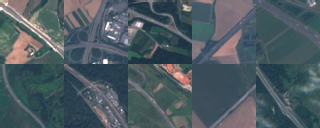

In [23]:
actual_img = [Image.open("./studies/Sagemaker_Study/SI/Highway/Highway/EuroSAT/Highway/Highway_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

We see that in terms of color and style there is a significant difference between Stable Diffusion direct generated images and the actual EuroSAT dataset images

## Fine-tune Stable Diffusion with LORA and DreamBooth
We want to fine-tune our text-to-image model to learn how to generate the right type of satellite images. To do so, we utilize two recent innovations, Dreambooth and LoRA. Dreambooth is a new method to allow models to learn to generate images that fit the distinct characteristics of the `instance` relative to the larger `class`. Low rank adapters (LoRA) allows for fast model training by drastically reducing the number of training parameters. We utilize the scripts found [here](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/README.md).

In [24]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py

--2023-06-23 05:25:28--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58646 (57K) [text/plain]
Saving to: ‘train_dreambooth_lora.py.1’

100%[======================================>] 58,646      --.-K/s   in 0.002s  

2023-06-23 05:25:28 (23.9 MB/s) - ‘train_dreambooth_lora.py.1’ saved [58646/58646]



In [25]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 24.7 MB/s eta 0:00:00:00:0100:01


In [27]:
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="./studies/Sagemaker_Study/SI/Highway/Highway/EuroSAT/Highway" \
  --output_dir=trained_model \
  --instance_prompt="Sentinel 2 satellite image of sks" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --report_to="tensorboard" \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --with_prior_preservation \
  --class_data_dir="./studies/Sagemaker_Study/SI/Highway/class" \
  --class_prompt="Sentinel 2 satellite image" \
  --max_train_steps=1000 \
  --seed="0" \
  --mixed_precision="fp16"

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
06/23/2023 05:30:50 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'thresholding', 'variance_type', 'dynamic_thresholding_ratio', 'clip_sample_range', 'prediction_type', 'sample_max_value'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'use_lin

Steps:  80%|████████  | 800/1000 [11:31<02:42,  1.23it/s, loss=0.352, lr=0.0001]06/23/2023 05:42:41 - INFO - accelerate.accelerator - Saving current state to trained_model/checkpoint-800
Model weights saved in trained_model/checkpoint-800/pytorch_lora_weights.bin
06/23/2023 05:42:41 - INFO - accelerate.checkpointing - Optimizer state saved in trained_model/checkpoint-800/optimizer.bin
06/23/2023 05:42:41 - INFO - accelerate.checkpointing - Scheduler state saved in trained_model/checkpoint-800/scheduler.bin
06/23/2023 05:42:41 - INFO - accelerate.checkpointing - Gradient scaler state saved in trained_model/checkpoint-800/scaler.pt
06/23/2023 05:42:41 - INFO - accelerate.checkpointing - Random states saved in trained_model/checkpoint-800/random_states_0.pkl
06/23/2023 05:42:41 - INFO - __main__ - Saved state to trained_model/checkpoint-800
Steps:  90%|████████ | 900/1000 [12:53<01:20,  1.25it/s, loss=0.0111, lr=0.0001]06/23/2023 05:44:03 - INFO - accelerate.accelerator - Saving current s

## Visualizing results
Now that the model is trained, let's compare:
1. Stable Diffusion generated images without fine-tuning
2. Stable Diffusion generated images with LoRA and Dreambooth fine-tuning
3. Original EuroSAT images

In [28]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

In [29]:
pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.18.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [30]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/25 [00:00<?, ?it/s]

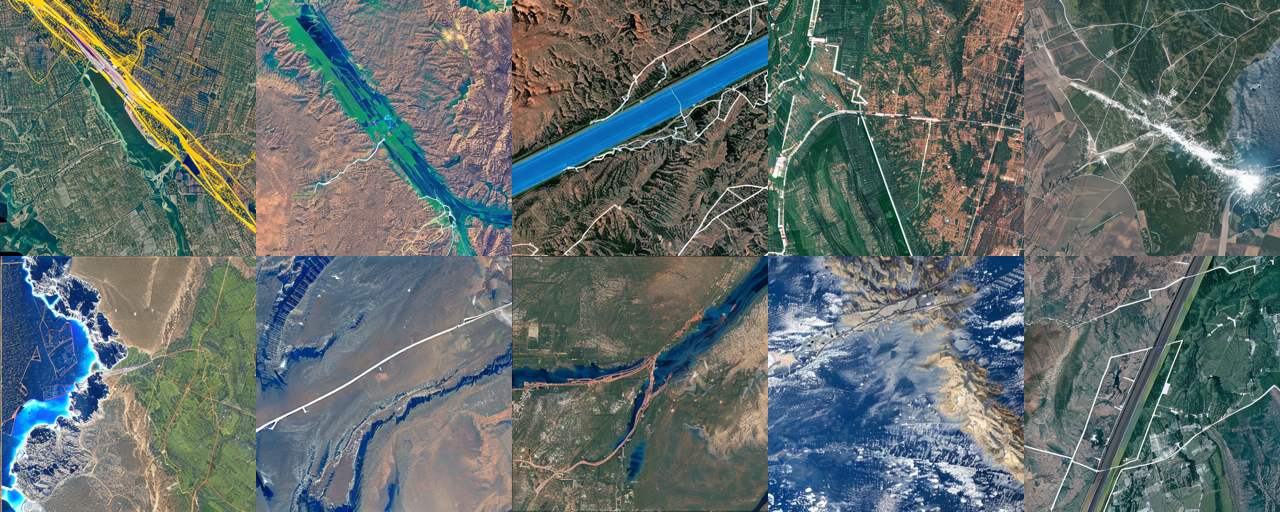

In [31]:
img_list = pipe(["Sentinel 2 satellite image of a highway"]*10, num_inference_steps=25).images
image_grid([x.resize((256,256)) for x in img_list], 2,5)

In [32]:
pipe.unet.load_attn_procs("./trained_model/checkpoint-800")

In [33]:
img_list = pipe(["Sentinel 2 satellite image of sks"]*10, num_inference_steps=25).images

  0%|          | 0/25 [00:00<?, ?it/s]

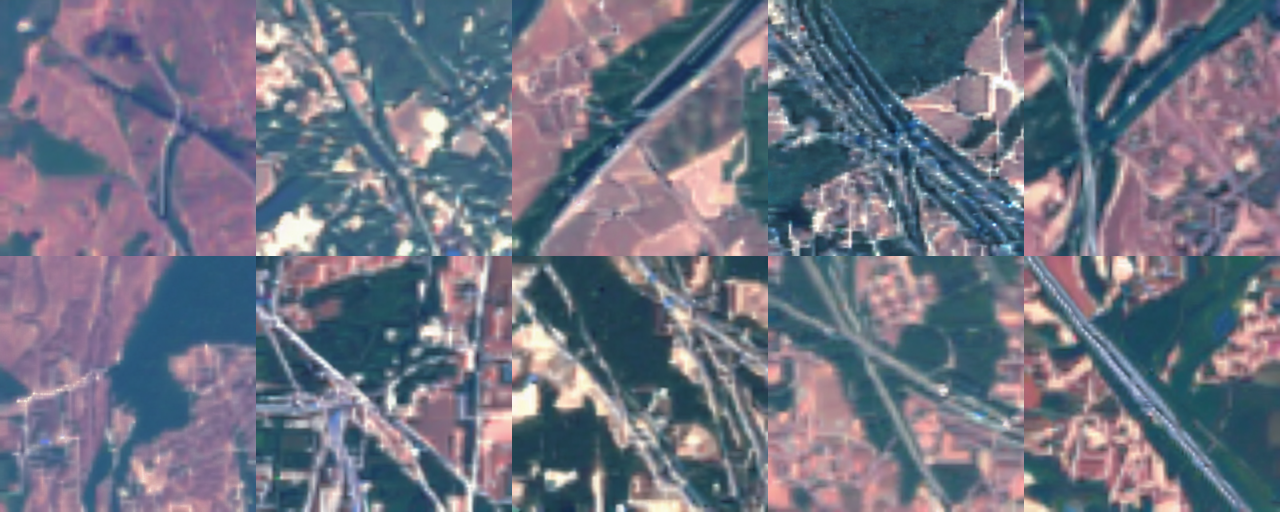

In [34]:
image_grid([x.resize((256,256)) for x in img_list], 2,5)

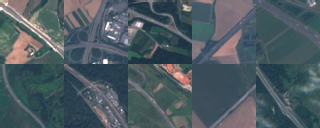

In [35]:
from PIL.ImageOps import exif_transpose
actual_img = [exif_transpose(Image.open("./studies/Sagemaker_Study/SI/Highway/Highway/EuroSAT/Highway/Highway_{}.jpg".format(str(i)))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

The generated images look much more realistic to before and we now have a lot more data to do whatever we wish with! 